# Report - ProgrammingTask

This Jupyter notebook will go through the different steps.

But first we have to import some libraries:

In [1]:
from dataprepper import DataPrepper
from datahandler import CSVDataHandler
from models import MirshekarianLSTM
from trainer import Trainer
from evaluator import Evaluator

import torch
import torch.nn as nn
import torch.optim as optim

from datahandler import CSVDataHandler
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from torch.utils.data import TensorDataset, DataLoader
#Getting rid of the annoying warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Dataset
### Ohio Dataset
#### Start with reading the data:

In [2]:
#Read data
participants = [559,563,570,575,588,591]
directory_path_train = os.path.join('Ohio Data', 'Ohio2018_processed', 'train')
train_handler = CSVDataHandler(directory_path_train, 'train')
train_handler.load_csv_files()


#### Short Feature Analysis

##### Factor Distribution

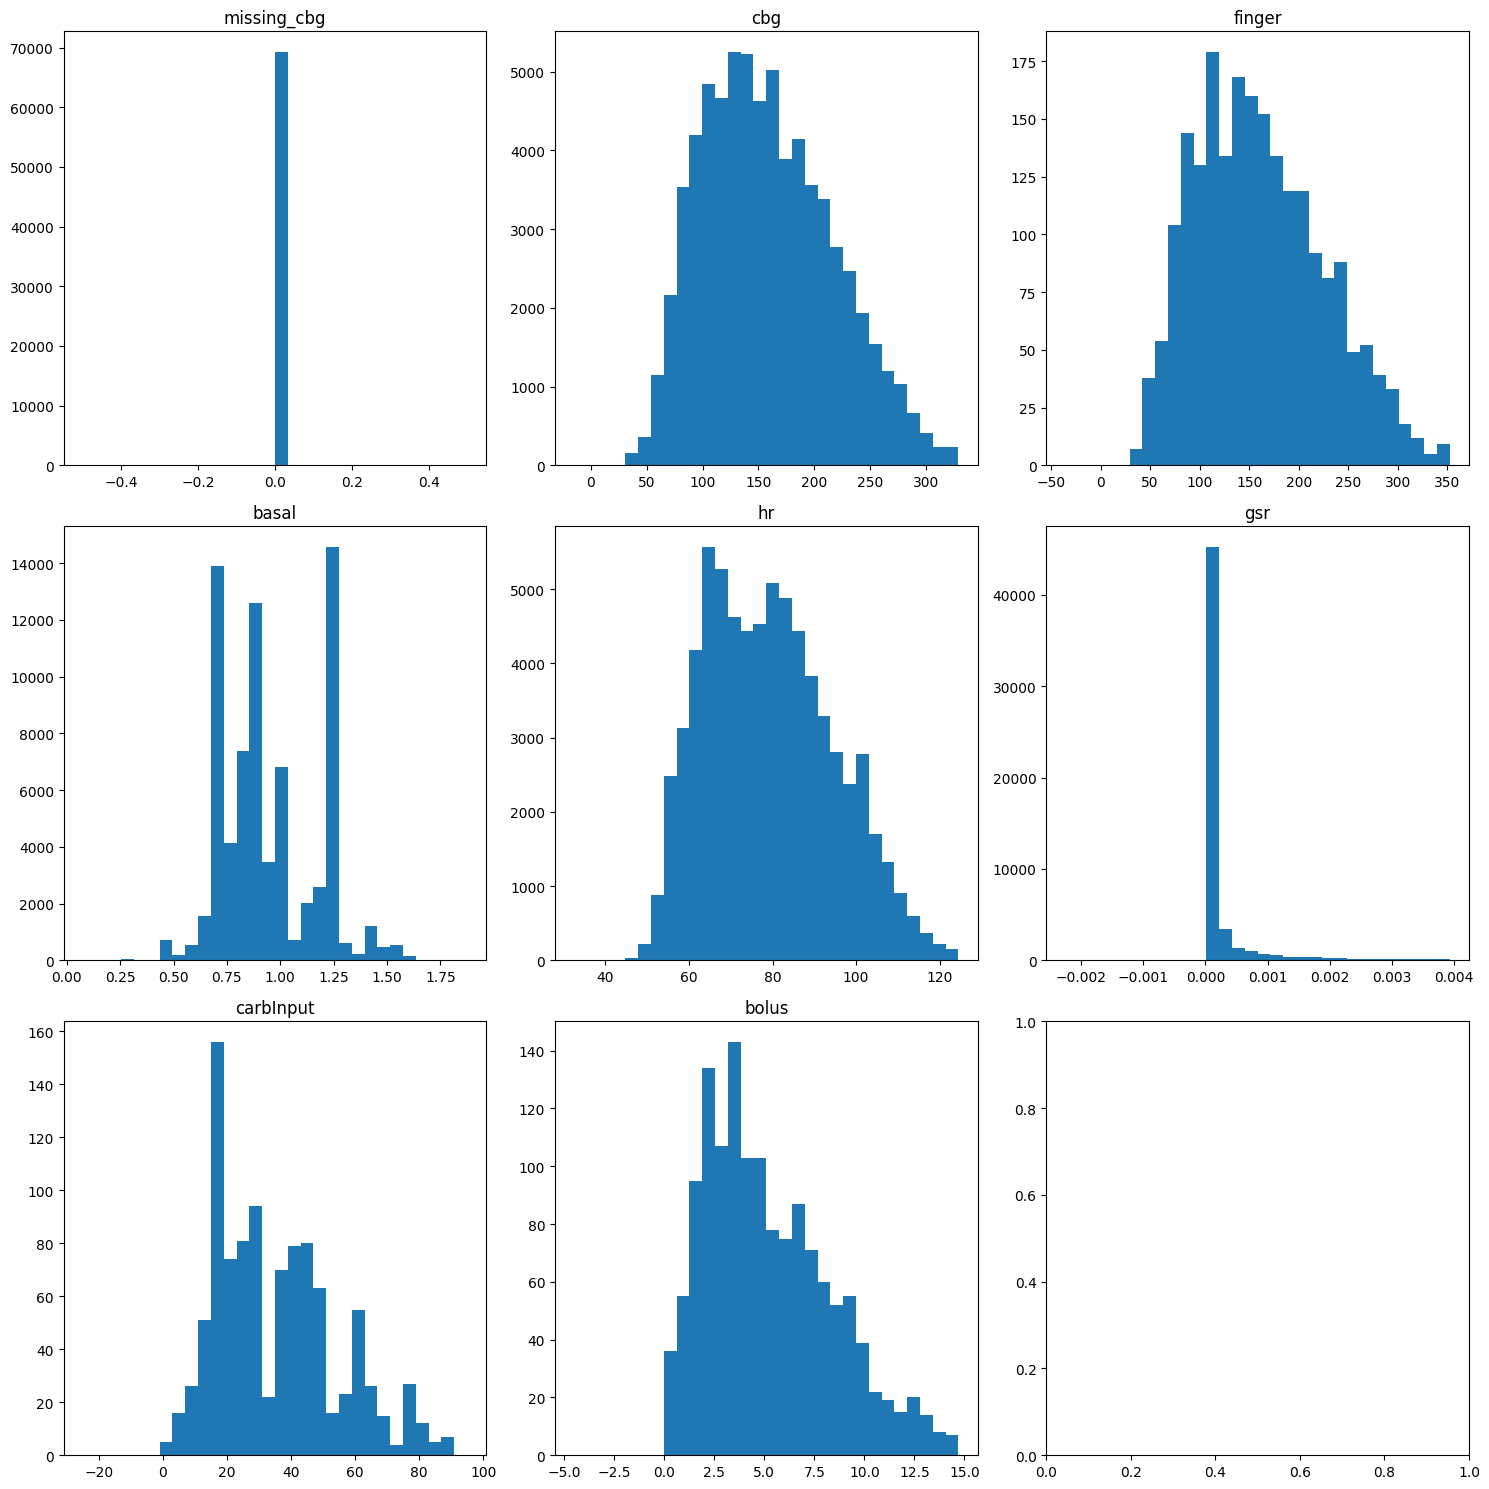

In [3]:
import math

df = train_handler.get_combined_df()
df = df.drop(columns='5minute_intervals_timestamp')
quantiles = df.quantile([0.25, 0.75])
Q1 = quantiles.loc[0.25]
Q3 = quantiles.loc[0.75]
IQR = Q3 - Q1

num_columns = 3
fig, axs = plt.subplots(math.ceil(len(df.columns) / num_columns), num_columns, figsize=(15, 15))

for i, column in enumerate(df.columns):
    axs.flat[i].hist(df[column].dropna(), range=(Q1[column] - 1.5*IQR[column], Q3[column] + 1.5*IQR[column]), bins=30)
    axs.flat[i].set_title(column)

fig.tight_layout()
plt.show()

#### Correlation Matrix

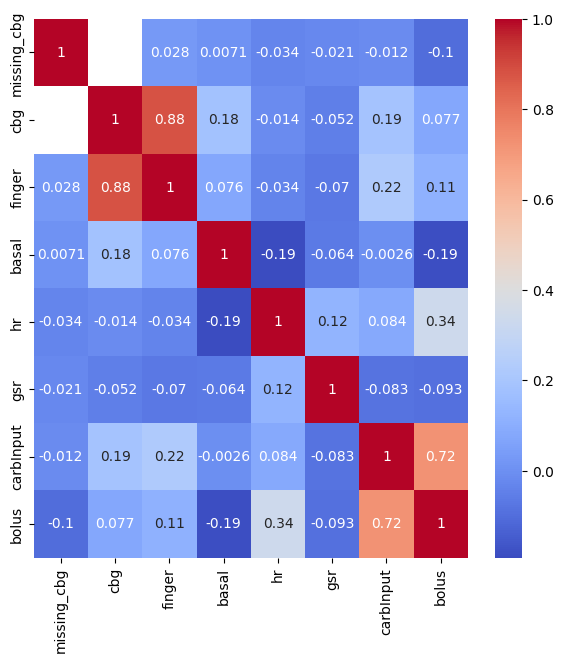

In [4]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(7,7))  # Adjust the size of the figure
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

## Data Preparation

### Feature Selection

In [5]:
features = ['cbg', 'basal', 'carbInput', 'bolus']

### Preprocessing

In [6]:
fill_types = ['cubicspline', 0, 0, 0]
train_handler.handle_missing_values(features, fill_types)

### Feature scaling

In [7]:
import joblib
scaler = StandardScaler()
scaler.fit(train_handler.get_combined_df()[features])
#Save scaler for later use
joblib.dump(scaler, "scalers"+os.sep+'scaler_2018.pkl')

['scalers\\scaler_2018.pkl']

## Experiments

#### Inter-patient Model
Use data from only the patient. 

### Design choices

Numbers of steps to forecast:

In [8]:
forecast_steps = 12

As all models will be trained in the same manner

In [9]:
def train_model_for_programming_task(participants, scaler, model_path='best_model.pth', forecast_steps=6, pretrained_model_path=None):
    features = ['cbg', 'basal', 'carbInput', 'bolus']
    fill_types = ['cubicspline', 0, 0, 0]

    directory_path_train = os.path.join('Ohio Data', 'Ohio2018_processed', 'train')
    train_handler = CSVDataHandler(directory_path_train, 'train')
    train_handler.load_csv_files()
    train_handler.handle_missing_values(features, fill_types)

    directory_path_test = os.path.join('Ohio Data', 'Ohio2018_processed', 'test')
    test_handler = CSVDataHandler(directory_path_test, 'test')
    test_handler.load_csv_files()
    test_handler.handle_missing_values(features, fill_types)


    #initialize data prepper and make features and target pair
    prepper = DataPrepper(participants, train_handler, forecast_steps=forecast_steps, scaler=scaler)
    features_train, target_train = prepper.make_features_and_targetpair()

    # Create TensorDatasets
    ########################
    # Split the training data into training and validation sets
    features_train, features_val, target_train, target_val = train_test_split(
        features_train, target_train, test_size=0.2, random_state=42)

    # Create TensorDatasets for the training and validation sets
    train_data = TensorDataset(features_train, target_train)
    val_data = TensorDataset(features_val, target_val)

    # Create DataLoaders
    batch_size = 32
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size)
    ########################

    model = MirshekarianLSTM(input_dim=4, hidden_dim=5, output_dim=1)
    #initialize model
    if pretrained_model_path != None:
        pretrained_model_dir = os.path.dirname(pretrained_model_path)
        if not os.path.exists(pretrained_model_dir):
            os.makedirs(pretrained_model_dir)
        model.load_state_dict(torch.load(pretrained_model_path))


    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Train the model
    trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, model_path=model_path)

    trainer.train()

#train_model_for_programming_task([559,563,570,575,588,591])


### Forcasting models

#### Intra-patient Model
Use data from all patients. Similates a model where there are no person ...

In [10]:
# Train one model from all data from all participants except test participant

for participant in participants:
    train_participants = [p for p in participants if p != participant]
    model_path = os.path.join('models', 'intra-patient', str(forecast_steps), f'best_model_{participant}.pth')
    train_model_for_programming_task(train_participants, scaler, model_path, forecast_steps)

c:\Users\knutj\OneDrive\PhDBern\ProgrammingTask\dataprepper.py:63: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:264.)
  return torch.FloatTensor(sequences), torch.FloatTensor(targets).view(-1, 1)


Epoch 1/100, Training Loss: 20938.09791591846, Validation Loss: 11927.809187805022, epochs_no_improve: 0
Epoch 2/100, Training Loss: 9355.434769945121, Validation Loss: 6164.033372547525, epochs_no_improve: 0
Epoch 3/100, Training Loss: 5837.469858606756, Validation Loss: 4341.562603928881, epochs_no_improve: 0
Epoch 4/100, Training Loss: 4653.092127860043, Validation Loss: 3670.310394978944, epochs_no_improve: 0
Epoch 5/100, Training Loss: 4143.639516662291, Validation Loss: 3319.0431816812124, epochs_no_improve: 0
Epoch 6/100, Training Loss: 3823.196885221851, Validation Loss: 3072.595094618329, epochs_no_improve: 0
Epoch 7/100, Training Loss: 3602.97182082169, Validation Loss: 2910.29631853464, epochs_no_improve: 0
Epoch 8/100, Training Loss: 3443.3231669889587, Validation Loss: 2820.8149442504578, epochs_no_improve: 0
Epoch 9/100, Training Loss: 3396.6564258796443, Validation Loss: 2896.026578888785, epochs_no_improve: 1
Epoch 10/100, Training Loss: 3418.401861272471, Validation Lo

In [11]:
# Evaluate the model on the test set
#One plot and rms score per participant

#### Inter-patient Model
Use data from only the patient. 

In [19]:
# Train one model per participant from only data from that participant

for participant in participants:
    train_participants = [participant]
    model_path = os.path.join('models', 'inter-patient', str(forecast_steps), f'best_model_{participant}.pth')
    train_model_for_programming_task(train_participants, scaler, model_path, forecast_steps)

Epoch 1/100, Training Loss: 31397.054972061258, Validation Loss: 28564.399722450657, epochs_no_improve: 0
Epoch 2/100, Training Loss: 25768.53967204315, Validation Loss: 23673.855417351973, epochs_no_improve: 0
Epoch 3/100, Training Loss: 21469.868836661837, Validation Loss: 19664.55689761513, epochs_no_improve: 0
Epoch 4/100, Training Loss: 17815.220884209437, Validation Loss: 16365.25841642681, epochs_no_improve: 0
Epoch 5/100, Training Loss: 14871.574225217302, Validation Loss: 13686.875642475328, epochs_no_improve: 0
Epoch 6/100, Training Loss: 12459.16920885503, Validation Loss: 11541.222476356908, epochs_no_improve: 0
Epoch 7/100, Training Loss: 10586.308554946192, Validation Loss: 9868.308561626234, epochs_no_improve: 0
Epoch 8/100, Training Loss: 9091.688384100302, Validation Loss: 8497.293977436266, epochs_no_improve: 0
Epoch 9/100, Training Loss: 7886.126220703125, Validation Loss: 7384.929427297492, epochs_no_improve: 0
Epoch 10/100, Training Loss: 6877.561732765855, Validat

#### Inter- and intra-patient Model

In [25]:
for participant in participants:
    train_participants = participants
    model_path = os.path.join('models', 'inter_and_intra-patient', str(forecast_steps), f'best_model_{participant}.pth')
    train_model_for_programming_task(train_participants, scaler, model_path, forecast_steps)

Epoch 1/100, Training Loss: 19400.910540231893, Validation Loss: 11247.045667200713, epochs_no_improve: 0
Epoch 2/100, Training Loss: 7606.826866105475, Validation Loss: 5919.858711412038, epochs_no_improve: 0
Epoch 3/100, Training Loss: 4696.394738281638, Validation Loss: 4496.590268560494, epochs_no_improve: 0
Epoch 4/100, Training Loss: 3815.6056574129316, Validation Loss: 3909.752873499348, epochs_no_improve: 0
Epoch 5/100, Training Loss: 3433.162457879603, Validation Loss: 3635.0476508755514, epochs_no_improve: 0
Epoch 6/100, Training Loss: 3182.103451100274, Validation Loss: 3426.994803805684, epochs_no_improve: 0
Epoch 7/100, Training Loss: 3025.7693679187587, Validation Loss: 3326.570779925421, epochs_no_improve: 0
Epoch 8/100, Training Loss: 2918.9488413110494, Validation Loss: 3211.92687227358, epochs_no_improve: 0
Epoch 9/100, Training Loss: 2831.0886924990023, Validation Loss: 3124.333199349821, epochs_no_improve: 0
Epoch 10/100, Training Loss: 2762.9791727464876, Validatio

#### Inter- and intra-patient Model - Transfer Learning
First pretrained on data from all patients. Then trained on data for the specific patient

In [20]:
# First pretrained on data from all patients. Then trained on data for the specific patient

for participant in participants:
    train_participants = [participant]
    pretrained_model_path = os.path.join('models', 'intra-patient', str(forecast_steps), f'best_model_{participant}.pth')
    model_path = os.path.join('models', 'inter_and_intra-patient_trans', str(forecast_steps), f'best_model_{participant}.pth')
    train_model_for_programming_task(train_participants, scaler, model_path, forecast_steps, pretrained_model_path)

Epoch 1/100, Training Loss: 1644.698743807559, Validation Loss: 1704.4035853335731, epochs_no_improve: 0
Epoch 2/100, Training Loss: 1606.6695588977132, Validation Loss: 1686.620122006065, epochs_no_improve: 0
Epoch 3/100, Training Loss: 1578.0154769594305, Validation Loss: 1696.4268710487768, epochs_no_improve: 1
Epoch 4/100, Training Loss: 1557.7548812967264, Validation Loss: 1661.8424120451275, epochs_no_improve: 0
Epoch 5/100, Training Loss: 1543.5693973768625, Validation Loss: 1698.8532907586348, epochs_no_improve: 1
Epoch 6/100, Training Loss: 1532.2469058005227, Validation Loss: 1670.63024179559, epochs_no_improve: 2
Early stopping triggered!
Epoch 1/100, Training Loss: 828.4467930225057, Validation Loss: 803.1845851991235, epochs_no_improve: 0
Epoch 2/100, Training Loss: 798.3878075835902, Validation Loss: 809.220356266673, epochs_no_improve: 1
Epoch 3/100, Training Loss: 799.6052930172795, Validation Loss: 825.411439104778, epochs_no_improve: 2
Early stopping triggered!
Epoch 

## Results

Code for evaluating the models:

In [21]:
def evaluate_model_for_programming_task(participants, scaler, model_path='best_model.pth', forecast_steps=6):
    #Read data
    
    features = ['cbg', 'basal', 'carbInput', 'bolus']
    fill_types = ['cubicspline', 0, 0, 0]

    directory_path_test = os.path.join('Ohio Data', 'Ohio2018_processed', 'test')
    test_handler = CSVDataHandler(directory_path_test, 'test')
    test_handler.load_csv_files()
    test_handler.handle_missing_values(features, fill_types)


    #initialize data prepper and make features and target pair

    prepper = DataPrepper(participants, test_handler, forecast_steps=forecast_steps, scaler=scaler)
    features_test, target_test = prepper.make_features_and_targetpair()

    # Create TensorDatasets
    ########################

    # Create TensorDatasets for the training and validation sets
    test_data = TensorDataset(features_test, target_test)

    # Create DataLoaders
    batch_size = 32
    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)
    ########################

    #initialize model
    model = MirshekarianLSTM(input_dim=4, hidden_dim=5, output_dim=1)

    # Load the state dict previously saved
    model.load_state_dict(torch.load(model_path))

    # Evaluate the model
    evaluator = Evaluator(model, test_loader)
    return evaluator.evaluate()

#### Intra-patient Model
Use data from all patients. Similates a model where there are no person ...

Root Mean Square Error (RMSE): 34.9663
Root Mean Square Error (RMSE): 30.9871
Root Mean Square Error (RMSE): 38.6454
Root Mean Square Error (RMSE): 36.9062
Root Mean Square Error (RMSE): 32.3093
Root Mean Square Error (RMSE): 33.6613


,Participant,RMSE
0,559,34.966267
1,563,30.987137
2,570,38.645370
3,575,36.906170
4,588,32.309292
5,591,33.661263


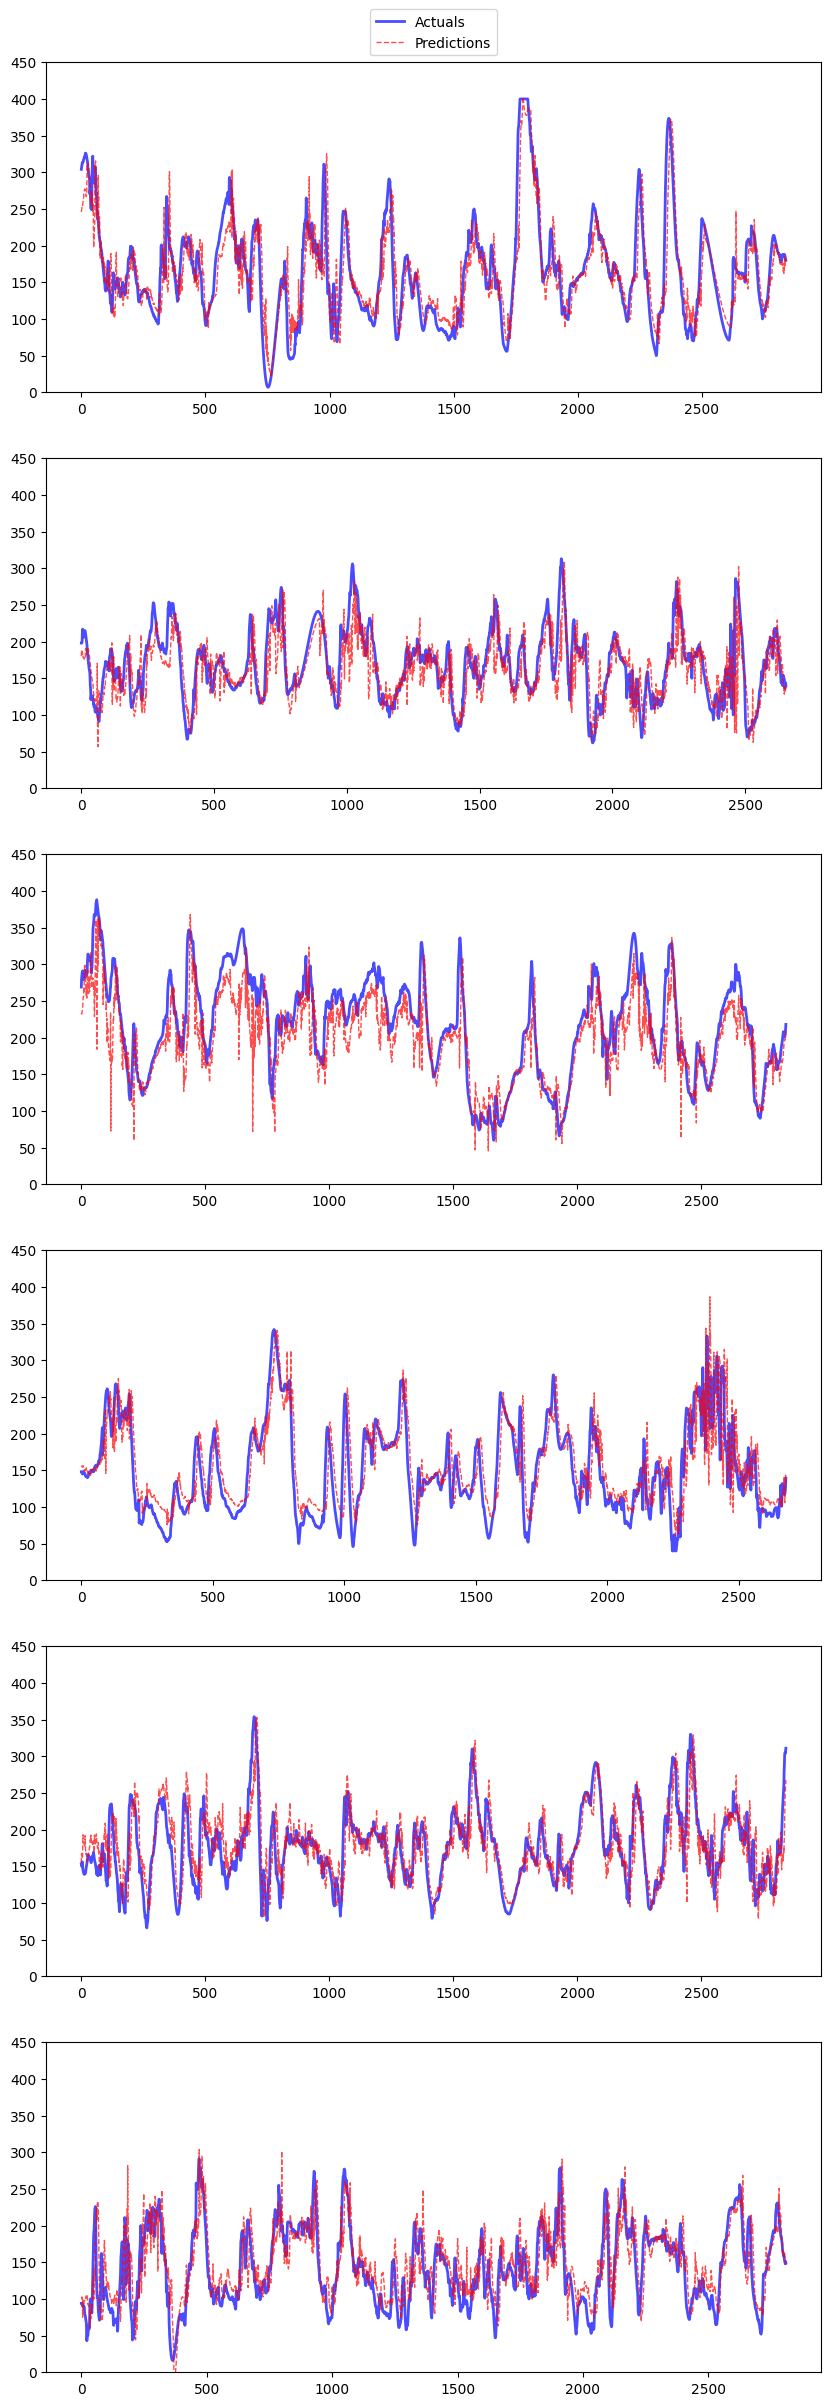

In [22]:
participants = [559,563,570,575,588,591]
plot_data = []
rmses = []
for participant in participants:
    test_participants = [participant]
    model_path = os.path.join('models', 'intra-patient', str(forecast_steps), f'best_model_{participant}.pth')
    predictions, actuals, rmse = evaluate_model_for_programming_task(test_participants, scaler, model_path, forecast_steps)
    plot_data.append((predictions, actuals))
    rmses.append(rmse)

rmse_df_intra = pd.DataFrame({'Participant': participants, 'RMSE': rmses})
display(rmse_df_intra)

fig, axs = plt.subplots(len(participants), 1, figsize=(10, 5 * len(participants)))
for i, (ax, data) in enumerate(zip(axs, plot_data)):
    predictions, actuals = data
    ax.plot(actuals, linestyle='-', linewidth=2, color='blue', alpha=0.7)
    ax.plot(predictions, linestyle='--', linewidth=1, color='red', alpha=0.7)
    if i == 0:
        ax.legend(['Actuals', 'Predictions'], loc='lower center', bbox_to_anchor=(0.5, 1.0))
    ax.set_ylim([0, 450])
plt.show()

#### Inter-patient Model
Use data from only the patient. 

Root Mean Square Error (RMSE): 33.3825
Root Mean Square Error (RMSE): 30.0669
Root Mean Square Error (RMSE): 29.5747
Root Mean Square Error (RMSE): 35.1860
Root Mean Square Error (RMSE): 56.2783
Root Mean Square Error (RMSE): 36.0945


,Participant,RMSE
0,559,33.382530
1,563,30.066856
2,570,29.574686
3,575,35.185955
4,588,56.278255
5,591,36.094463


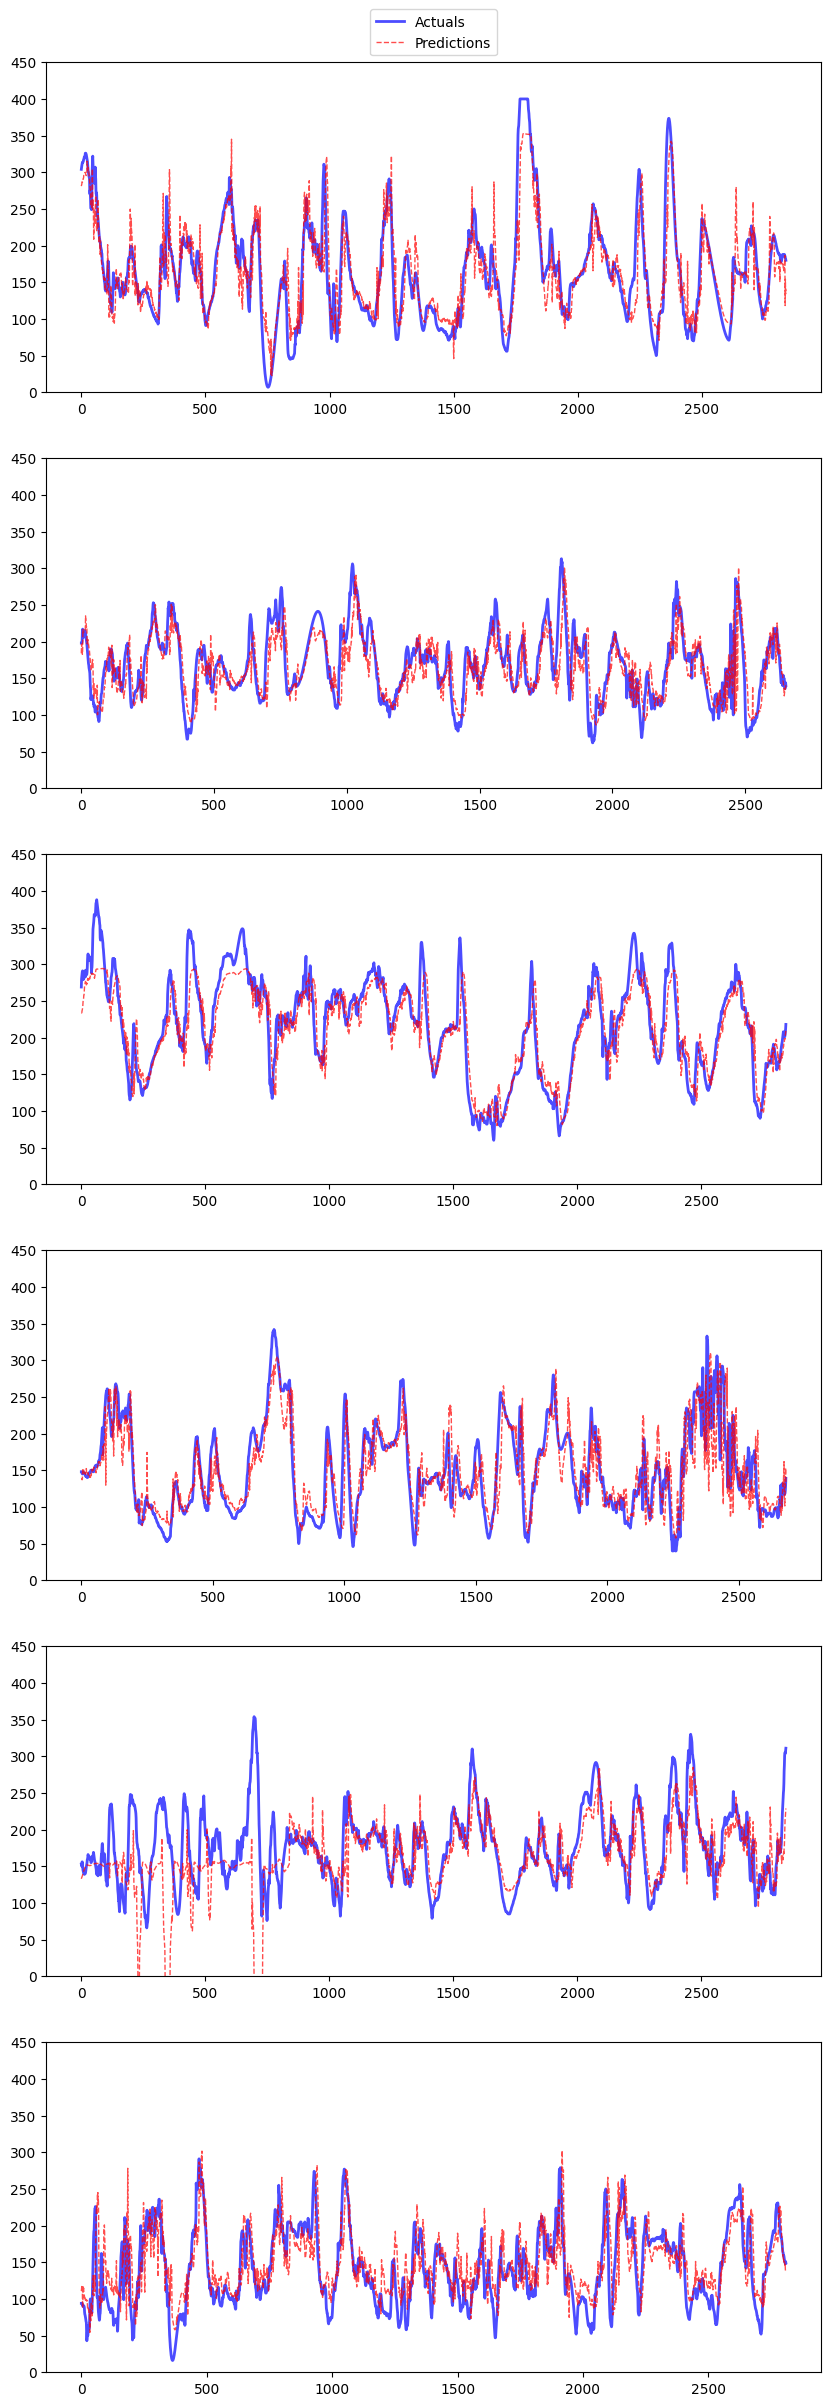

In [23]:
participants = [559,563,570,575,588,591]
plot_data = []
rmses = []
for participant in participants:
    test_participants = [participant]
    model_path = os.path.join('models', 'inter-patient', str(forecast_steps), f'best_model_{participant}.pth')
    predictions, actuals, rmse = evaluate_model_for_programming_task(test_participants, scaler, model_path, forecast_steps)
    plot_data.append((predictions, actuals))
    rmses.append(rmse)

rmse_df_inter = pd.DataFrame({'Participant': participants, 'RMSE': rmses})
display(rmse_df_inter)

fig, axs = plt.subplots(len(participants), 1, figsize=(10, 5 * len(participants)))
for i, (ax, data) in enumerate(zip(axs, plot_data)):
    predictions, actuals = data
    ax.plot(actuals, linestyle='-', linewidth=2, color='blue', alpha=0.7)
    ax.plot(predictions, linestyle='--', linewidth=1, color='red', alpha=0.7)
    if i == 0:
        ax.legend(['Actuals', 'Predictions'], loc='lower center', bbox_to_anchor=(0.5, 1.0))
    ax.set_ylim([0, 450])
plt.show()

#### Inter- and intra-patient Model


Root Mean Square Error (RMSE): 33.6073
Root Mean Square Error (RMSE): 29.5601
Root Mean Square Error (RMSE): 29.0844
Root Mean Square Error (RMSE): 35.7492
Root Mean Square Error (RMSE): 30.8091
Root Mean Square Error (RMSE): 34.4999


,Participant,RMSE
0,559,33.607273
1,563,29.560051
2,570,29.084431
3,575,35.749199
4,588,30.809071
5,591,34.499912


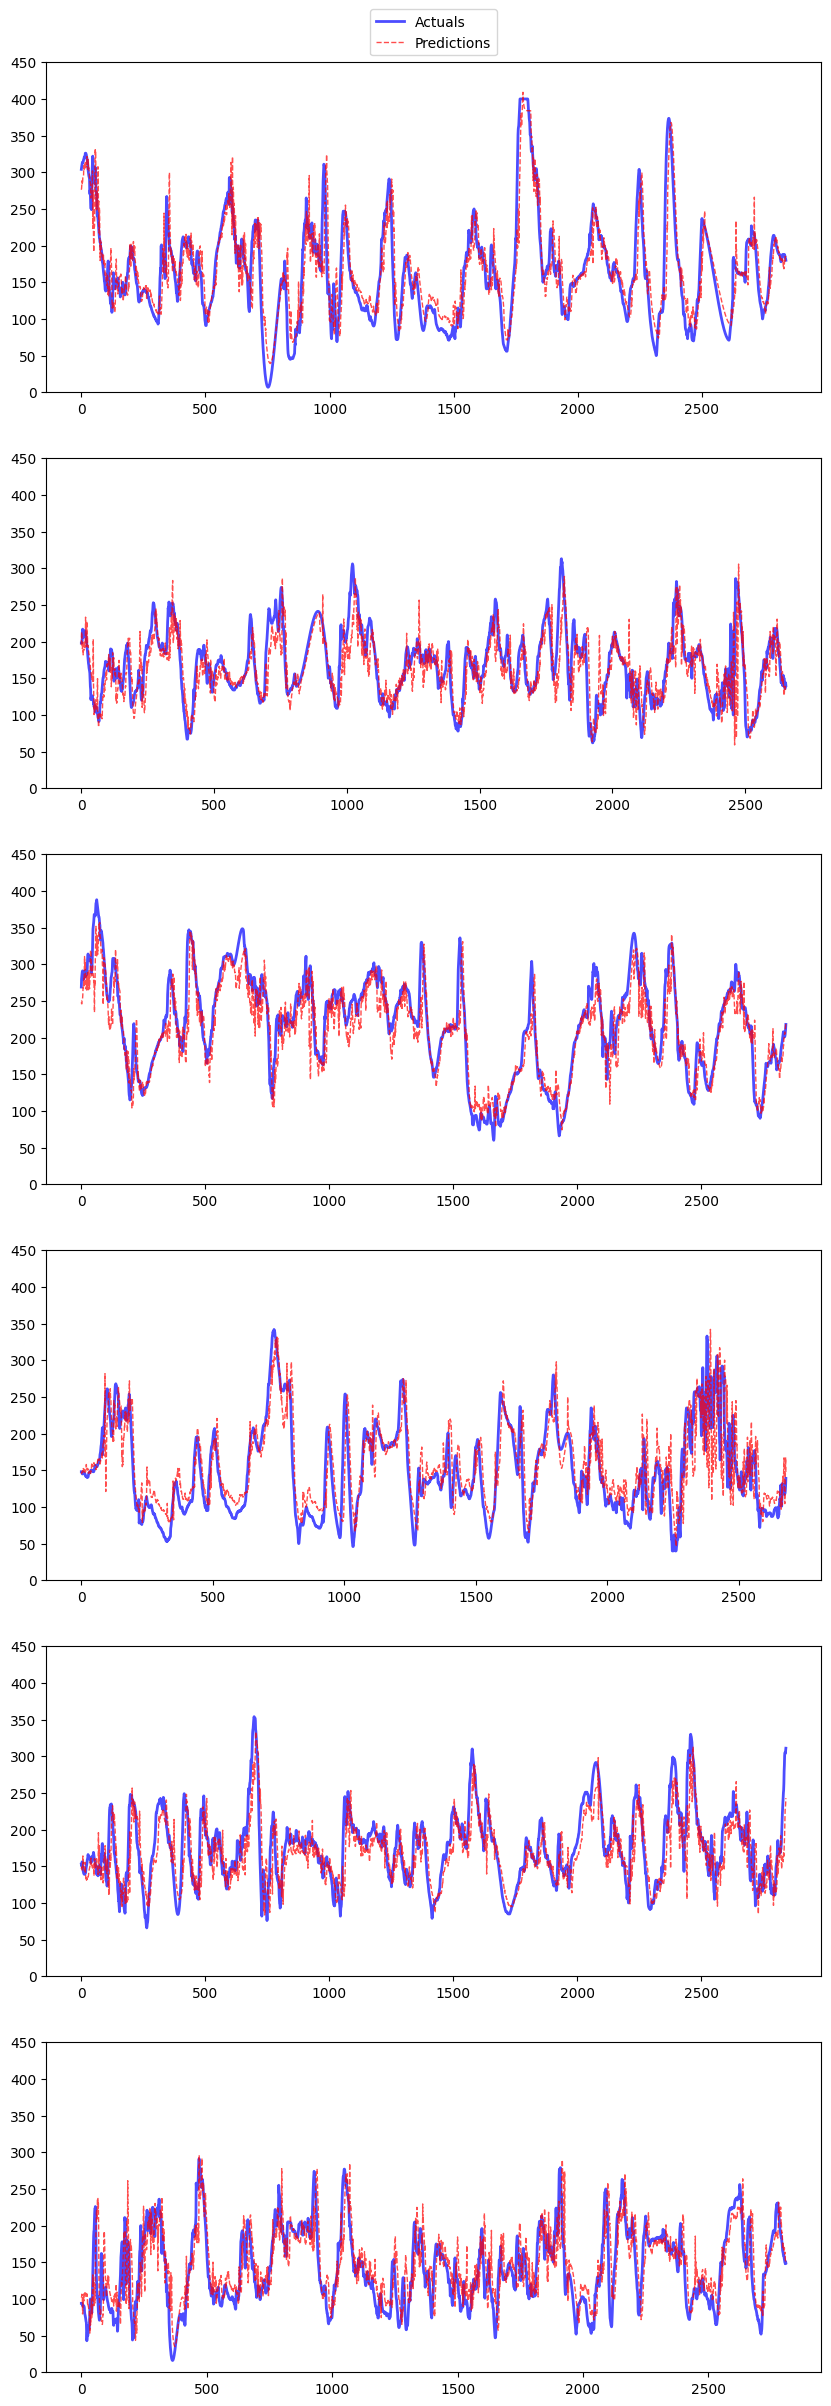

In [26]:
participants = [559,563,570,575,588,591]
plot_data = []
rmses = []
for participant in participants:
    test_participants = [participant]
    model_path = os.path.join('models', 'inter_and_intra-patient', str(forecast_steps), f'best_model_{participant}.pth')
    predictions, actuals, rmse = evaluate_model_for_programming_task(test_participants, scaler, model_path, forecast_steps)
    plot_data.append((predictions, actuals))
    rmses.append(rmse)

rmse_df_inter_and_intra_patient = pd.DataFrame({'Participant': participants, 'RMSE': rmses})
display(rmse_df_inter_and_intra_patient)

fig, axs = plt.subplots(len(participants), 1, figsize=(10, 5 * len(participants)))
for i, (ax, data) in enumerate(zip(axs, plot_data)):
    predictions, actuals = data
    ax.plot(actuals, linestyle='-', linewidth=2, color='blue', alpha=0.7)
    ax.plot(predictions, linestyle='--', linewidth=1, color='red', alpha=0.7)
    if i == 0:
        ax.legend(['Actuals', 'Predictions'], loc='lower center', bbox_to_anchor=(0.5, 1.0))
    ax.set_ylim([0, 450])
plt.show()

#### Inter- and intra-patient Model - Transfer Learning 
First pretrained on data from all patients. Then trained on data for the specific patient

Root Mean Square Error (RMSE): 32.0230
Root Mean Square Error (RMSE): 29.4267
Root Mean Square Error (RMSE): 27.0546
Root Mean Square Error (RMSE): 36.1209
Root Mean Square Error (RMSE): 38.4936
Root Mean Square Error (RMSE): 33.4334


,Participant,RMSE
0,559,32.023010
1,563,29.426680
2,570,27.054552
3,575,36.120869
4,588,38.493633
5,591,33.433422


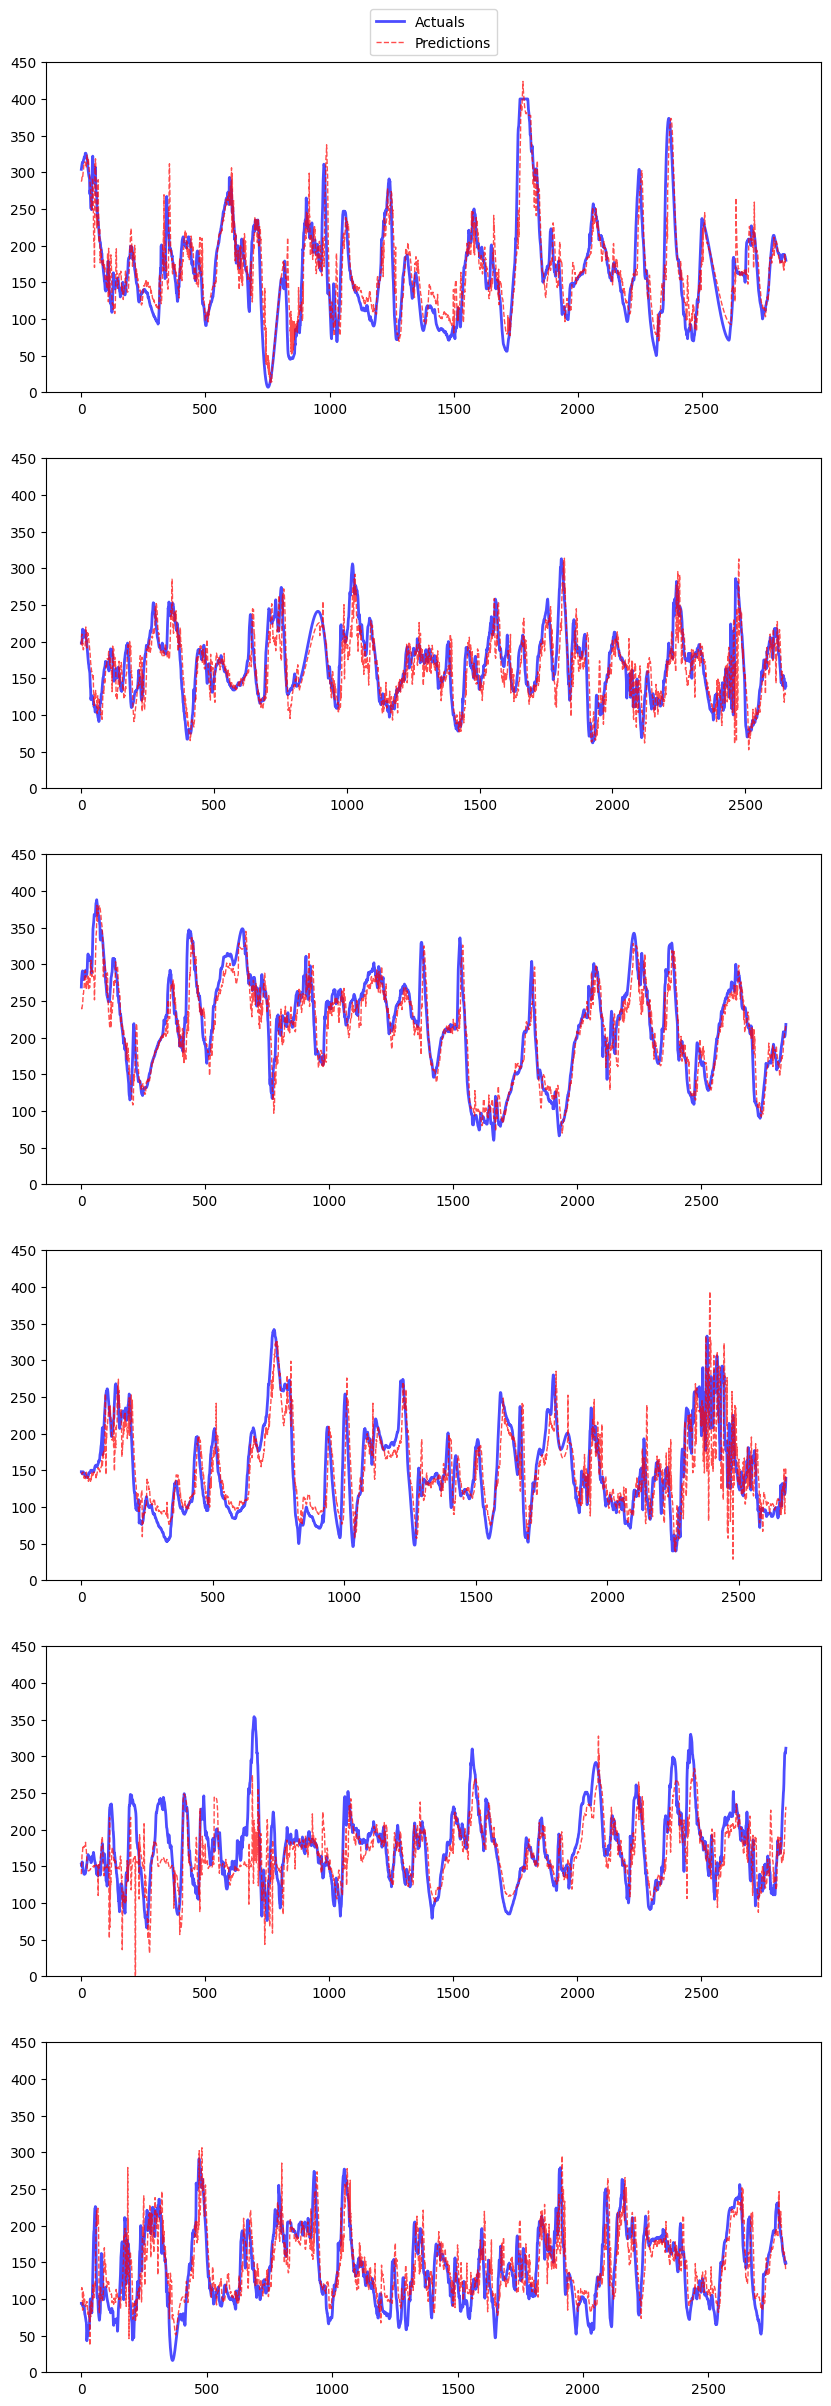

In [27]:
participants = [559,563,570,575,588,591]
plot_data = []
rmses = []
for participant in participants:
    test_participants = [participant]
    model_path = os.path.join('models', 'inter_and_intra-patient_trans', str(forecast_steps), f'best_model_{participant}.pth')
    predictions, actuals, rmse = evaluate_model_for_programming_task(test_participants, scaler, model_path, forecast_steps)
    plot_data.append((predictions, actuals))
    rmses.append(rmse)

rmse_df_inter_and_intra_patient_trans = pd.DataFrame({'Participant': participants, 'RMSE': rmses})
display(rmse_df_inter_and_intra_patient_trans)

fig, axs = plt.subplots(len(participants), 1, figsize=(10, 5 * len(participants)))
for i, (ax, data) in enumerate(zip(axs, plot_data)):
    predictions, actuals = data
    ax.plot(actuals, linestyle='-', linewidth=2, color='blue', alpha=0.7)
    ax.plot(predictions, linestyle='--', linewidth=1, color='red', alpha=0.7)
    if i == 0:
        ax.legend(['Actuals', 'Predictions'], loc='lower center', bbox_to_anchor=(0.5, 1.0))
    ax.set_ylim([0, 450])
plt.show()

,Model,RMSE
0,Inter- and intra-patient,32.218323
1,Inter- and intra-patient (Transfer Learning),32.758694
2,Inter-patient,36.763791
3,Intra-patient,34.579250


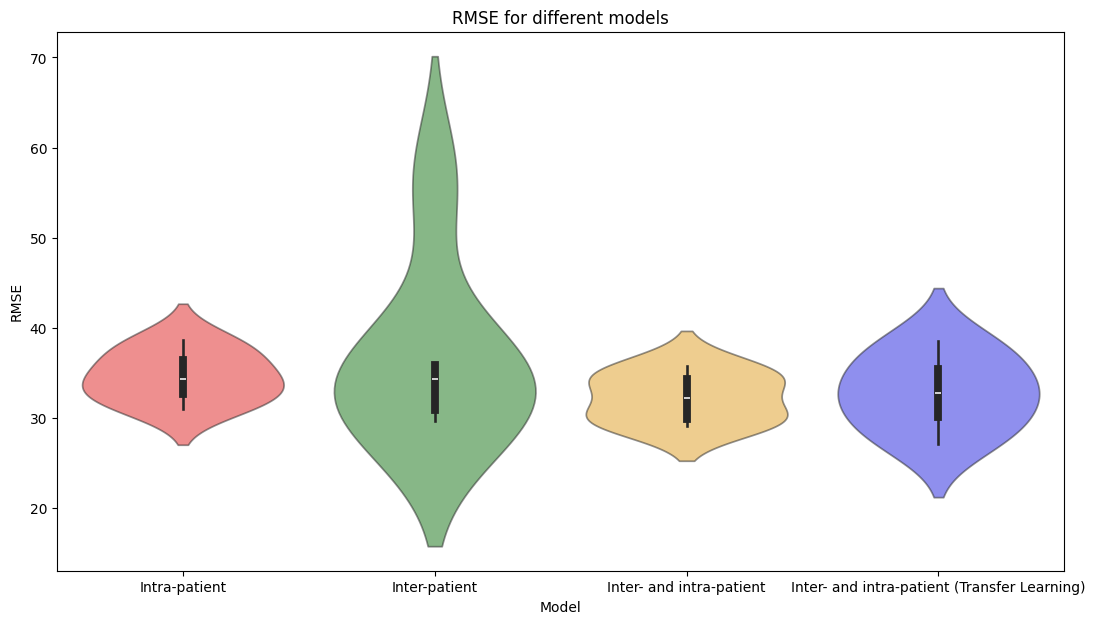

In [29]:
# Concatenate the dataframes
rmse_df = pd.concat([rmse_df_intra.assign(Model='Intra-patient'),
                     rmse_df_inter.assign(Model='Inter-patient'),
                     rmse_df_inter_and_intra_patient.assign(Model='Inter- and intra-patient'),
                     rmse_df_inter_and_intra_patient_trans.assign(Model='Inter- and intra-patient (Transfer Learning)')])

# Define a color palette
colors = {'Intra-patient': 'red', 'Inter-patient': 'green', 'Inter- and intra-patient': 'orange', 'Inter- and intra-patient (Transfer Learning)': 'blue'}

# Calculate the average RMSE per model
avg_rmse_df = rmse_df.groupby('Model')['RMSE'].mean().reset_index()
display(avg_rmse_df)

# Plot the violin plot
plt.figure(figsize=(13, 7))
sns.violinplot(x='Model', y='RMSE', data=rmse_df, palette=colors, alpha=0.5)
plt.title('RMSE for different models')
plt.show()
